In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cPickle as pickle

from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.learning_curve import validation_curve, learning_curve

from lignet_utils import gen_train_test, calc_r_squared_dt
from constant import Y_COLUMNS
from plotting_utils import pplot_one_output_full

%matplotlib inline

In [2]:
x_train, x_test, y_train, y_test, x_scaler, y_scaler = gen_train_test()

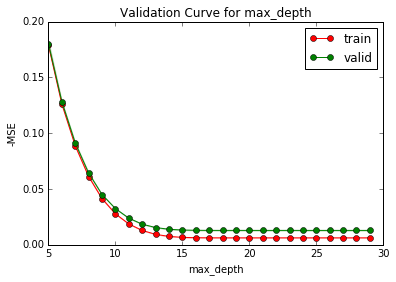

In [73]:
# Make a validation curve for the max depth parameter
train_size = int(0.5 * x_train.shape[0])
xt = x_train[:train_size, :]
yt = y_train[:train_size, :]

param_range = range(5, 30)
train_scores, valid_scores = validation_curve(tree.DecisionTreeRegressor(
        min_samples_leaf=5),
                                              xt, yt, 'max_depth', param_range,
                                              scoring='mean_squared_error')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.title('Validation Curve for max_depth')
plt.xlabel("max_depth")
plt.ylabel("-MSE")

plt.plot(param_range, -train_scores_mean, 'o-', label='train', color='r')
plt.fill_between(param_range, -train_scores_mean - train_scores_std,
                -train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(param_range, -valid_scores_mean, 'o-', label='valid', color='g')
plt.fill_between(param_range, -valid_scores_mean - valid_scores_std,
                -valid_scores_mean + valid_scores_std, alpha=0.2, color='g')
plt.legend(loc=0)

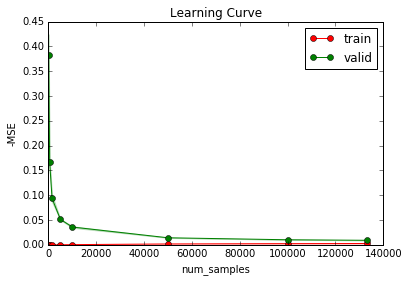

In [3]:
# Make a learning curve to find out how much training data to use
train_size = int(1 * x_train.shape[0])
xt = x_train[:train_size, :]
yt = y_train[:train_size, :]

train_sizes, train_scores, valid_scores = learning_curve(
    tree.DecisionTreeRegressor(max_depth=15), xt, yt,
    train_sizes=[100, 500, 1500, 5000, 10000, 50000, 100000, 133333],
    scoring='mean_squared_error')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.title('Learning Curve')
plt.xlabel("num_samples")
plt.ylabel("-MSE")

plt.plot(train_sizes, -train_scores_mean, 'o-', label='train', color='r')
plt.fill_between(train_sizes, -train_scores_mean - train_scores_std,
                -train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(train_sizes, -valid_scores_mean, 'o-', label='valid', color='g')
plt.fill_between(train_sizes, -valid_scores_mean - valid_scores_std,
                -valid_scores_mean + valid_scores_std, alpha=0.2, color='g')
plt.legend(loc=0)

If I use the parameters found by the gridsearch (28, 1), then I get a perfect fit to ALL training data, which obviously leads to poorer generalization.  Using (26, 1) actually achieves better test fits with many of the output measures.  Raising the min_samples_leaf above 1 results in better generalization scores - from experimentation it looks like a value of 2 is best.  The best architecture I can find is (26, 2).

In [4]:
dtr_full = tree.DecisionTreeRegressor(max_depth=26, min_samples_leaf=2)
dtr_full = dtr_full.fit(x_train, y_train)
calc_r_squared_dt(dtr_full, x_train, x_test, y_train, y_test)

{'ALL': (0.9989, 0.99374),
 'CO': (0.99848, 0.99211),
 'CO2': (0.99946, 0.99771),
 'H-C-ratio': (0.99912, 0.99598),
 'H20': (0.99916, 0.9952),
 'Moisture': (0.99909, 0.99574),
 'heavy_C--O': (0.99744, 0.98463),
 'heavy_aliphatic_C-C': (0.99857, 0.98247),
 'heavy_aliphatic_C-O': (0.99811, 0.98795),
 'heavy_aromatic_C-C': (0.9983, 0.98927),
 'heavy_aromatic_C-H': (0.99943, 0.99704),
 'heavy_aromatic_C-O': (0.99933, 0.99724),
 'heavy_aromatic_methoxyl': (0.9994, 0.99747),
 'heavytars': (0.99818, 0.99123),
 'light_C--O': (0.99873, 0.99233),
 'light_aliphatic_C-C': (0.99908, 0.99602),
 'light_aliphatic_C-O': (0.99768, 0.98462),
 'light_aromatic_C-H': (0.99913, 0.99549),
 'light_aromatic_C-O': (0.99913, 0.99543),
 'lighttars': (0.99946, 0.99726),
 'othergases': (0.99913, 0.99575),
 'solids': (0.9982, 0.99098),
 'tot_C--O': (0.99948, 0.9979),
 'tot_aliphaticC-C': (0.99952, 0.99798),
 'tot_aliphaticC-O': (0.99891, 0.99335),
 'tot_aromaticC-C': (0.99848, 0.99099),
 'tot_aromaticC-H': (0.9995, 0

In [6]:
# pickle the trained regressor
with open('trained_networks/decision_tree.pkl', 'wb') as pkl:
    pickle.dump([dtr_full], pkl)

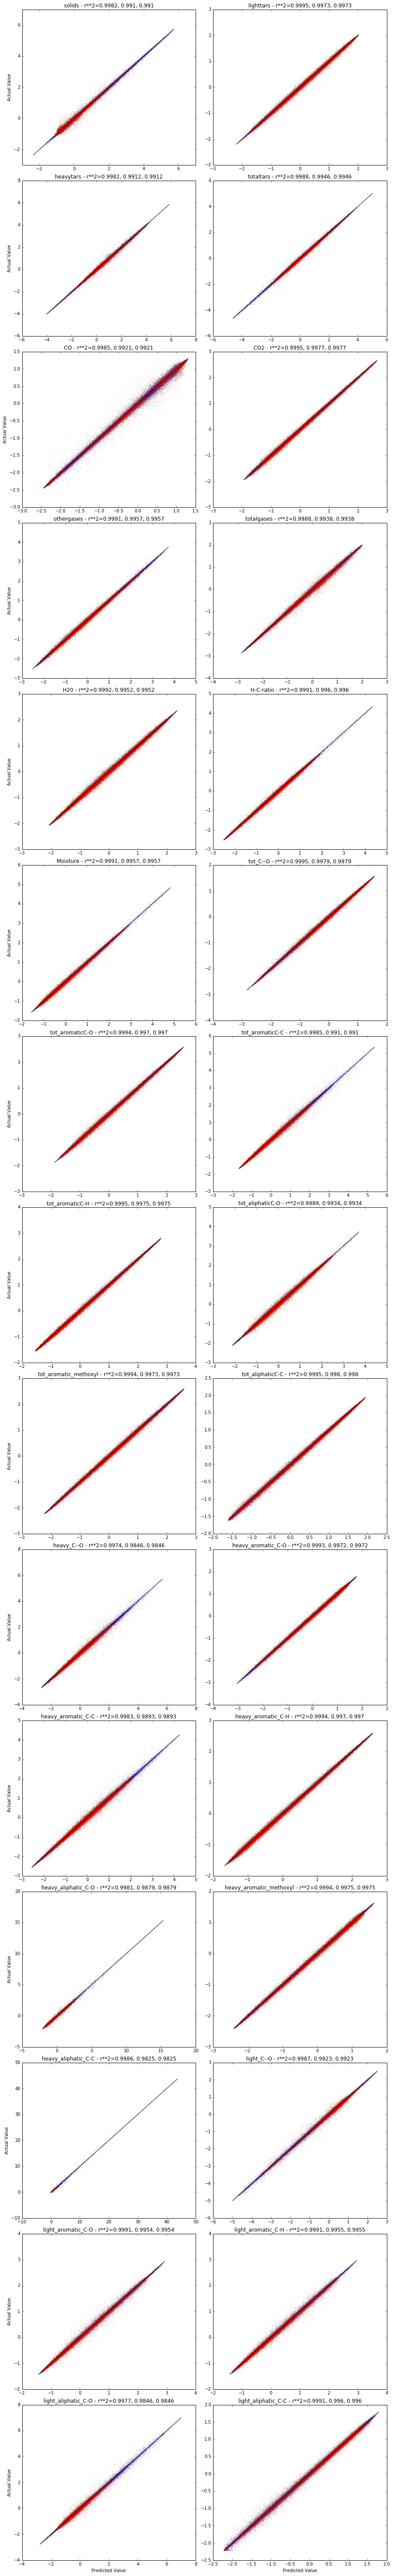

In [5]:
# Parity plots for the output measures in the full tree
# note there is no validation set so the test set is given twice
output_list = Y_COLUMNS
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=False,
                     sharey=False, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

ytpred = dtr_full.predict(x_train)
ytestpred = dtr_full.predict(x_test)
yvpred = ytestpred

for key, name in enumerate(output_list):
    pplot_one_output_full(ax, y_train, y_test, y_test,
                          ytpred, yvpred, ytestpred, key)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.1)

In [5]:
# tree.export_graphviz(dtr_full)
# from os import system
# system('dot -Tsvg tree.dot -o tree.svg')

0